In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain


### Helpers

In [2]:
mu0 = 4 * np.pi * 10**-7

def estore_from_approx_beta_poloidal(Ip, beta, R0):
    return np.power(Ip,2)*beta*R0*3.0/8.0*mu0

from omfit_classes.omfit_eqdsk import boundaryShape

### Build machine

In [3]:
r,z,zeff= boundaryShape(kapu = 1.65, kapl = 1.65, delu = -0.4, dell = -0.4, zetail = -.2, zetaiu = -.2, zetaou = 0, zetaol = 0, a = 0.35, eps = 0.35/0.83, zoffset = 0, upnull = False, lonull = False, npts = 8)
vv_pts = np.column_stack((r,z))
coils = {
    'CS0': {'rc': 0.375, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.375, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.375, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': .588, 'zc': 0.53, 'w': 0.1, 'h': 0.1},
    'EF1U': {'rc': 1.1, 'zc': 0.74, 'w': 0.1, 'h': 0.1},
    'EF2U': {'rc': 1.25, 'zc': 0.6, 'w': 0.1, 'h': 0.1},
    'EF3U': {'rc': 1.7, 'zc': 0.3, 'w': .1, 'h': .1},

    'EF0L': {'rc': .588, 'zc': -0.53, 'w': 0.1, 'h': 0.1},
    'EF1L': {'rc': 1.1, 'zc': -0.74, 'w': 0.1, 'h': 0.1},
    'EF2L': {'rc': 1.25, 'zc': -0.6, 'w': 0.1, 'h': 0.1},
    'EF3L': {'rc': 1.7, 'zc': -0.3, 'w': .1, 'h': .1},
  
}

In [4]:
## Define mesh resolution in each region
plasma_resolution = 0.03
coil_resolution = 0.03
vv_resolution = 0.03
vac_resolution = 0.075

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')      # Define the bounding region
gs_mesh.define_region('plasma',plasma_resolution,'plasma')  # Define the plasma region and resolution
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [6]:
# Define vaccum vessel geometry
gs_mesh.add_polygon(vv_pts,'plasma',parent_name='air')             # Define the shape of the limiter
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

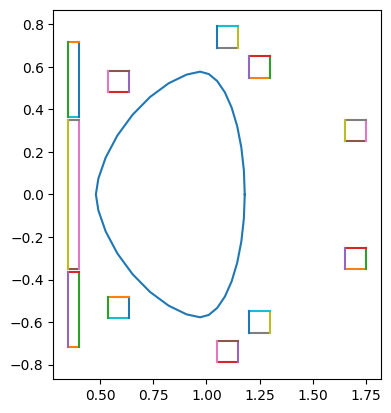

In [7]:
## Plot geometry
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [8]:
#Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 394
  # of unique segments  = 49
Generating mesh:
  # of points  = 2257
  # of cells   = 4406
  # of regions = 13


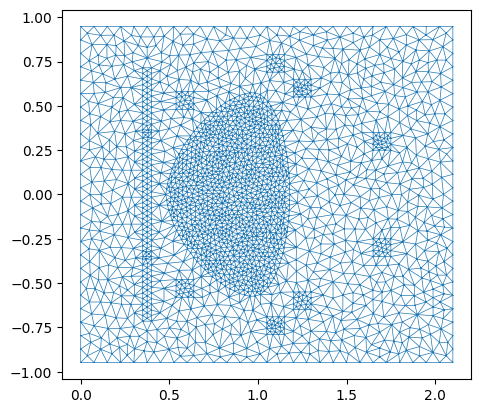

In [9]:
# Plot mesh
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1], lw = 0.5)

### Set Targets

In [10]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.8*3) ## F0 = R0 * B0

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.982E+00
    # of points  =    2257
    # of edges   =    6662
    # of cells   =    4406
    # of boundary points =     106
    # of boundary edges  =     106
    # of boundary cells  =     106
  Resolution statistics:
    hmin =  1.500E-02
    hrms =  4.838E-02
    hmax =  1.101

In [11]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[2,2] = 1
targets[0] = -5E5
targets[1] = -5E5 
targets[2] = -5E5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)


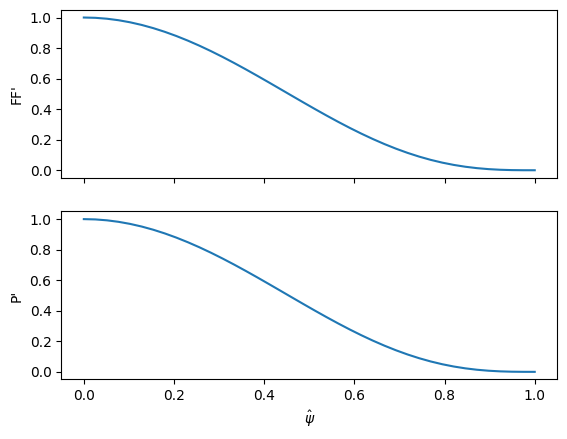

In [12]:
# Define shape of P' anf FF' profiles

n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [13]:
#Define global quantities
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1) #Can change poloidal beta by modifying Ip_ratio target

In [14]:
##Set shape targets
kappa = 1.7
delta = -0.5

r, z, zeff = boundaryShape(kapu = kappa, kapl = kappa, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.8, zoffset = 0, upnull = True, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
isoflux_weights = 10*np.ones(32)
mygs.set_isoflux(boundary, isoflux_weights)

#Set saddle targets
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)



In [15]:
mygs.init_psi(0.8,0,0.22, kappa,delta) #Initial "guess"
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  8.4970E+00  6.2655E+00  4.1768E-02  8.3971E-01  2.5407E-05 -0.0000E+00
     2  9.3717E+00  6.9075E+00  1.3280E-02  8.4064E-01  2.5426E-05 -0.0000E+00
     3  9.7084E+00  7.1568E+00  4.5009E-03  8.4102E-01  2.7356E-05 -0.0000E+00
     4  9.8775E+00  7.2826E+00  1.8111E-03  8.4118E-01  2.8322E-05 -0.0000E+00
     5  9.9666E+00  7.3493E+00  8.3278E-04  8.4124E-01  2.8423E-05 -0.0000E+00
     6  1.0014E+01  7.3850E+00  4.1360E-04  8.4126E-01  2.8121E-05 -0.0000E+00
     7  1.0040E+01  7.4043E+00  2.1379E-04  8.4126E-01  2.7771E-05 -0.0000E+00
     8  1.0053E+01  7.4147E+00  1.1287E-04  8.4126E-01  2.7445E-05 -0.0000E+00
     9  1.0061E+01  7.4204E+00  6.0343E-05  8.4126E-01  2.7178E-05 -0.0000E+00
    10  1.0065E+01  7.4234E+00  3.2519E-05  8.4125E-01  2.6968E-05 -0.0000E+00
    11  1.0067E+01  7.4251E+00  1.7626E-05  8.4125E-01  2.6804E-05 -0.0000E+00
    12  1.0068E+01  7.4260E+00  9.5977E-06  8.4125E-01  2.6677E-05 -0.0000E+00
    13  1.0069E+01  7.

0

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9999E+05
  Current Centroid [m]    =    0.828  0.000
  Magnetic Axis [m]       =    0.841  0.000
  Elongation              =    1.654 (U:  1.608, L:  1.699)
  Triangularity           =   -0.415 (U: -0.350, L: -0.481)
  Plasma Volume [m^3]     =    1.689
  q_0, q_95               =    0.613  2.336
  Peak Pressure [Pa]      =    4.0608E+05
  Stored Energy [J]       =    1.8322E+05
  <Beta_pol> [%]          =   51.7594
  <Beta_tor> [%]          =    2.1635
  Diamagnetic flux [Wb]   =    9.8813E-03
  Toroidal flux [Wb]      =    1.0111E+00
  l_i                     =    1.2385


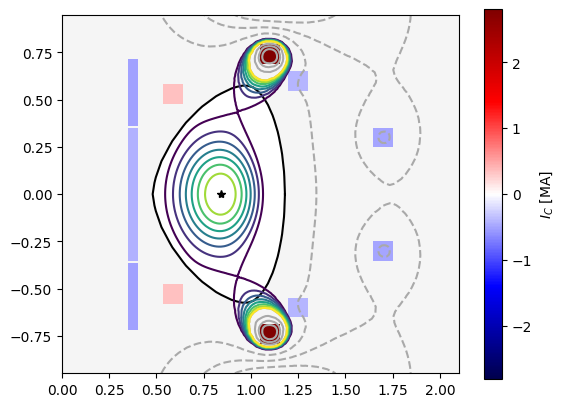

In [16]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.print_info()

In [17]:
## Print equilibrium info
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9999E+05
  Current Centroid [m]    =    0.828  0.000
  Magnetic Axis [m]       =    0.841  0.000
  Elongation              =    1.654 (U:  1.608, L:  1.699)
  Triangularity           =   -0.415 (U: -0.350, L: -0.481)
  Plasma Volume [m^3]     =    1.689
  q_0, q_95               =    0.613  2.336
  Peak Pressure [Pa]      =    4.0608E+05
  Stored Energy [J]       =    1.8322E+05
  <Beta_pol> [%]          =   51.7594
  <Beta_tor> [%]          =    2.1635
  Diamagnetic flux [Wb]   =    9.8813E-03
  Toroidal flux [Wb]      =    1.0111E+00
  l_i                     =    1.2385

Coil Currents [MA]:
  CS0:            -0.52
  CS1:            -0.42
  CS2:            -0.51
  EF0U:            0.34
  EF1U:            2.80
  EF2U:           -0.41
  EF3U:           -0.50
  EF0L:            0.34
  EF1L:            2.81
  EF2L:           -0.41
  EF3L:           -0.50
